## Import Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!pip install missingpy
from missingpy import MissForest
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 51kB 2.3MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Preprocessing

In [5]:
url1 = 'https://raw.githubusercontent.com/maxwelth/airline/main/train.csv'
url2 = 'https://raw.githubusercontent.com/maxwelth/airline/main/test.csv'

In [6]:
df_train = pd.read_csv(url1)

In [7]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [13]:
df_train = df_train.drop(columns=['Unnamed: 0','id'])

In [14]:
df_train.shape

(103904, 23)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

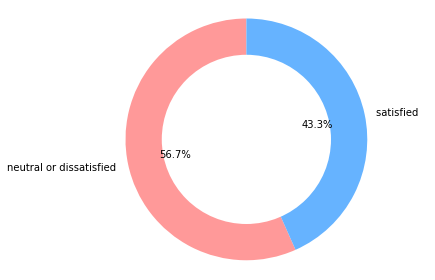

In [16]:
#check label imbalance
labels = ['neutral or dissatisfied', 'satisfied ']
sizes = [100*(df_train['satisfaction'].value_counts()[0]/df_train['satisfaction'].value_counts().sum()), 100*(df_train['satisfaction'].value_counts()[1]/df_train['satisfaction'].value_counts().sum())]
colors = ['#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='White')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

### Deal with Missing Value

In [11]:
#check missing value
df_train.isnull().sum().sort_values(ascending=False).head()

Arrival Delay in Minutes    310
satisfaction                  0
Gate location                 0
id                            0
Gender                        0
dtype: int64

In [17]:
#impute missing data with random forest
MFimputer = MissForest()
Xmf = df_train.select_dtypes(exclude='object')
MFimputer.fit(Xmf)
X_imputed = MFimputer.transform(Xmf)
X_imputed = pd.DataFrame(X_imputed, columns=Xmf.columns)  #convert array to dataframe
df_train['Arrival Delay in Minutes'] = X_imputed['Arrival Delay in Minutes']

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [18]:
#recheck missing value
df_train.isnull().sum().sort_values(ascending=False).head()

satisfaction      0
Food and drink    0
Customer Type     0
Age               0
Type of Travel    0
dtype: int64

### Numerical Data Distribution

In [19]:
#numerical columns
num_sus = [df_train[df_train.columns[x]].nunique() for x in range(len(df_train.columns)) if df_train[df_train.columns[x]].nunique()>10 and df_train[df_train.columns[x]].nunique()<4000]
num_col = [x for r in range(len(num_sus)) for x in df_train.columns if df_train[x].nunique()==num_sus[r]]

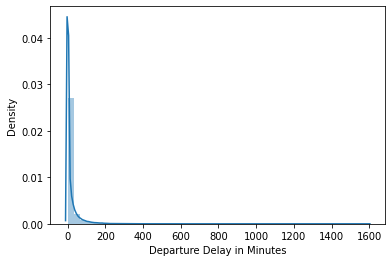

In [20]:
#check distribution of 'Departure Delay'(minutes)
sns.distplot(df_train[num_col[2]])

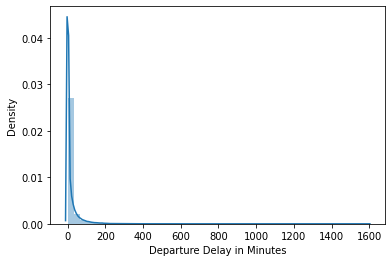

In [21]:
#check distribution of 'Arrival Delay'(minutes)
sns.distplot(df_train[num_col[2]])

##### Both 'Arrival Delay' and 'Departure Delay' distribution are extremely right skewed. Scaling would help to normalize the distribution

### Encoding Categorical Variable and Target

In [22]:
#check their unique value (to assign number based on intrinsic oder for unique value >2)
for i in df_train.select_dtypes(include='object').drop(columns=['satisfaction']).columns:
    print(df_train[i].value_counts(ascending=False))
    print('Jumlah Distinct Value :', df_train[i].nunique())
    print(34*'-')

Female    52727
Male      51177
Name: Gender, dtype: int64
Jumlah Distinct Value : 2
----------------------------------
Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64
Jumlah Distinct Value : 2
----------------------------------
Business travel    71655
Personal Travel    32249
Name: Type of Travel, dtype: int64
Jumlah Distinct Value : 2
----------------------------------
Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64
Jumlah Distinct Value : 3
----------------------------------


In [23]:
df_train['Gender']=df_train['Gender'].map({'Female': 1,'Male': 0})
df_train['Customer Type']=df_train['Customer Type'].map({'Loyal Customer': 1,'disloyal Customer': 0})
df_train['Type of Travel']=df_train['Type of Travel'].map({'Business travel': 1,'Personal Travel': 0})
df_train['Class']=df_train['Class'].map({'Eco': 1,'Eco Plus': 2,'Business': 3})

df_train['satisfaction']=df_train['satisfaction'].map({'neutral or dissatisfied': 0,'satisfied': 1})

### Correlation and Feature Selection

In [24]:
#check correlation
df_train.corr()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
Gender,1.000000,-0.031732,-0.008928,0.006909,-0.008253,-0.005828,-0.008974,-0.009142,-0.006951,-0.000333,-0.005772,0.042260,0.026502,-0.006117,-0.008156,-0.031798,-0.037391,-0.010563,-0.039410,-0.006505,-0.002935,-0.000797,-0.012211
Customer Type,-0.031732,1.000000,0.281674,-0.308333,0.105735,0.225200,0.007543,0.206869,0.019509,-0.006078,0.059454,0.189262,0.159484,0.109930,0.056560,0.047868,-0.024723,0.032177,-0.022670,0.083613,-0.004036,-0.004478,0.187638
Age,-0.008928,0.281674,1.000000,0.048524,0.140565,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,0.057594,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.010152,-0.012152,0.137167
Type of Travel,0.006909,-0.308333,0.048524,1.000000,0.545257,0.267344,0.105085,-0.259763,0.133511,0.030700,0.063439,0.224803,0.124399,0.148199,0.056543,0.138803,0.031321,-0.016751,0.022599,0.079207,0.005432,0.005080,0.449000
Class,-0.008253,0.105735,0.140565,0.545257,1.000000,0.451211,0.036279,-0.092788,0.106391,0.004150,0.085908,0.322924,0.227444,0.194366,0.209505,0.204964,0.160460,0.151613,0.156353,0.135818,-0.009637,-0.013715,0.494471
Flight Distance,-0.005828,0.225200,0.099461,0.267344,0.451211,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,0.109526,0.133916,0.063184,0.073072,0.057540,0.093149,0.002158,-0.002165,0.298780
Inflight wifi service,-0.008974,0.007543,0.017859,0.105085,0.036279,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,0.121500,0.160473,0.120923,0.043193,0.110441,0.132698,-0.017402,-0.019069,0.284245
Departure/Arrival time convenient,-0.009142,0.206869,0.038125,-0.259763,-0.092788,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,0.068882,0.012441,0.072126,0.093333,0.073318,0.014292,0.001005,-0.000664,-0.051601
Ease of Online booking,-0.006951,0.019509,0.024842,0.133511,0.106391,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,0.038833,0.107601,0.038762,0.011081,0.035272,0.016179,-0.006371,-0.008092,0.171705
Gate location,-0.000333,-0.006078,-0.001330,0.030700,0.004150,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,-0.028373,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.005467,0.005052,0.000682


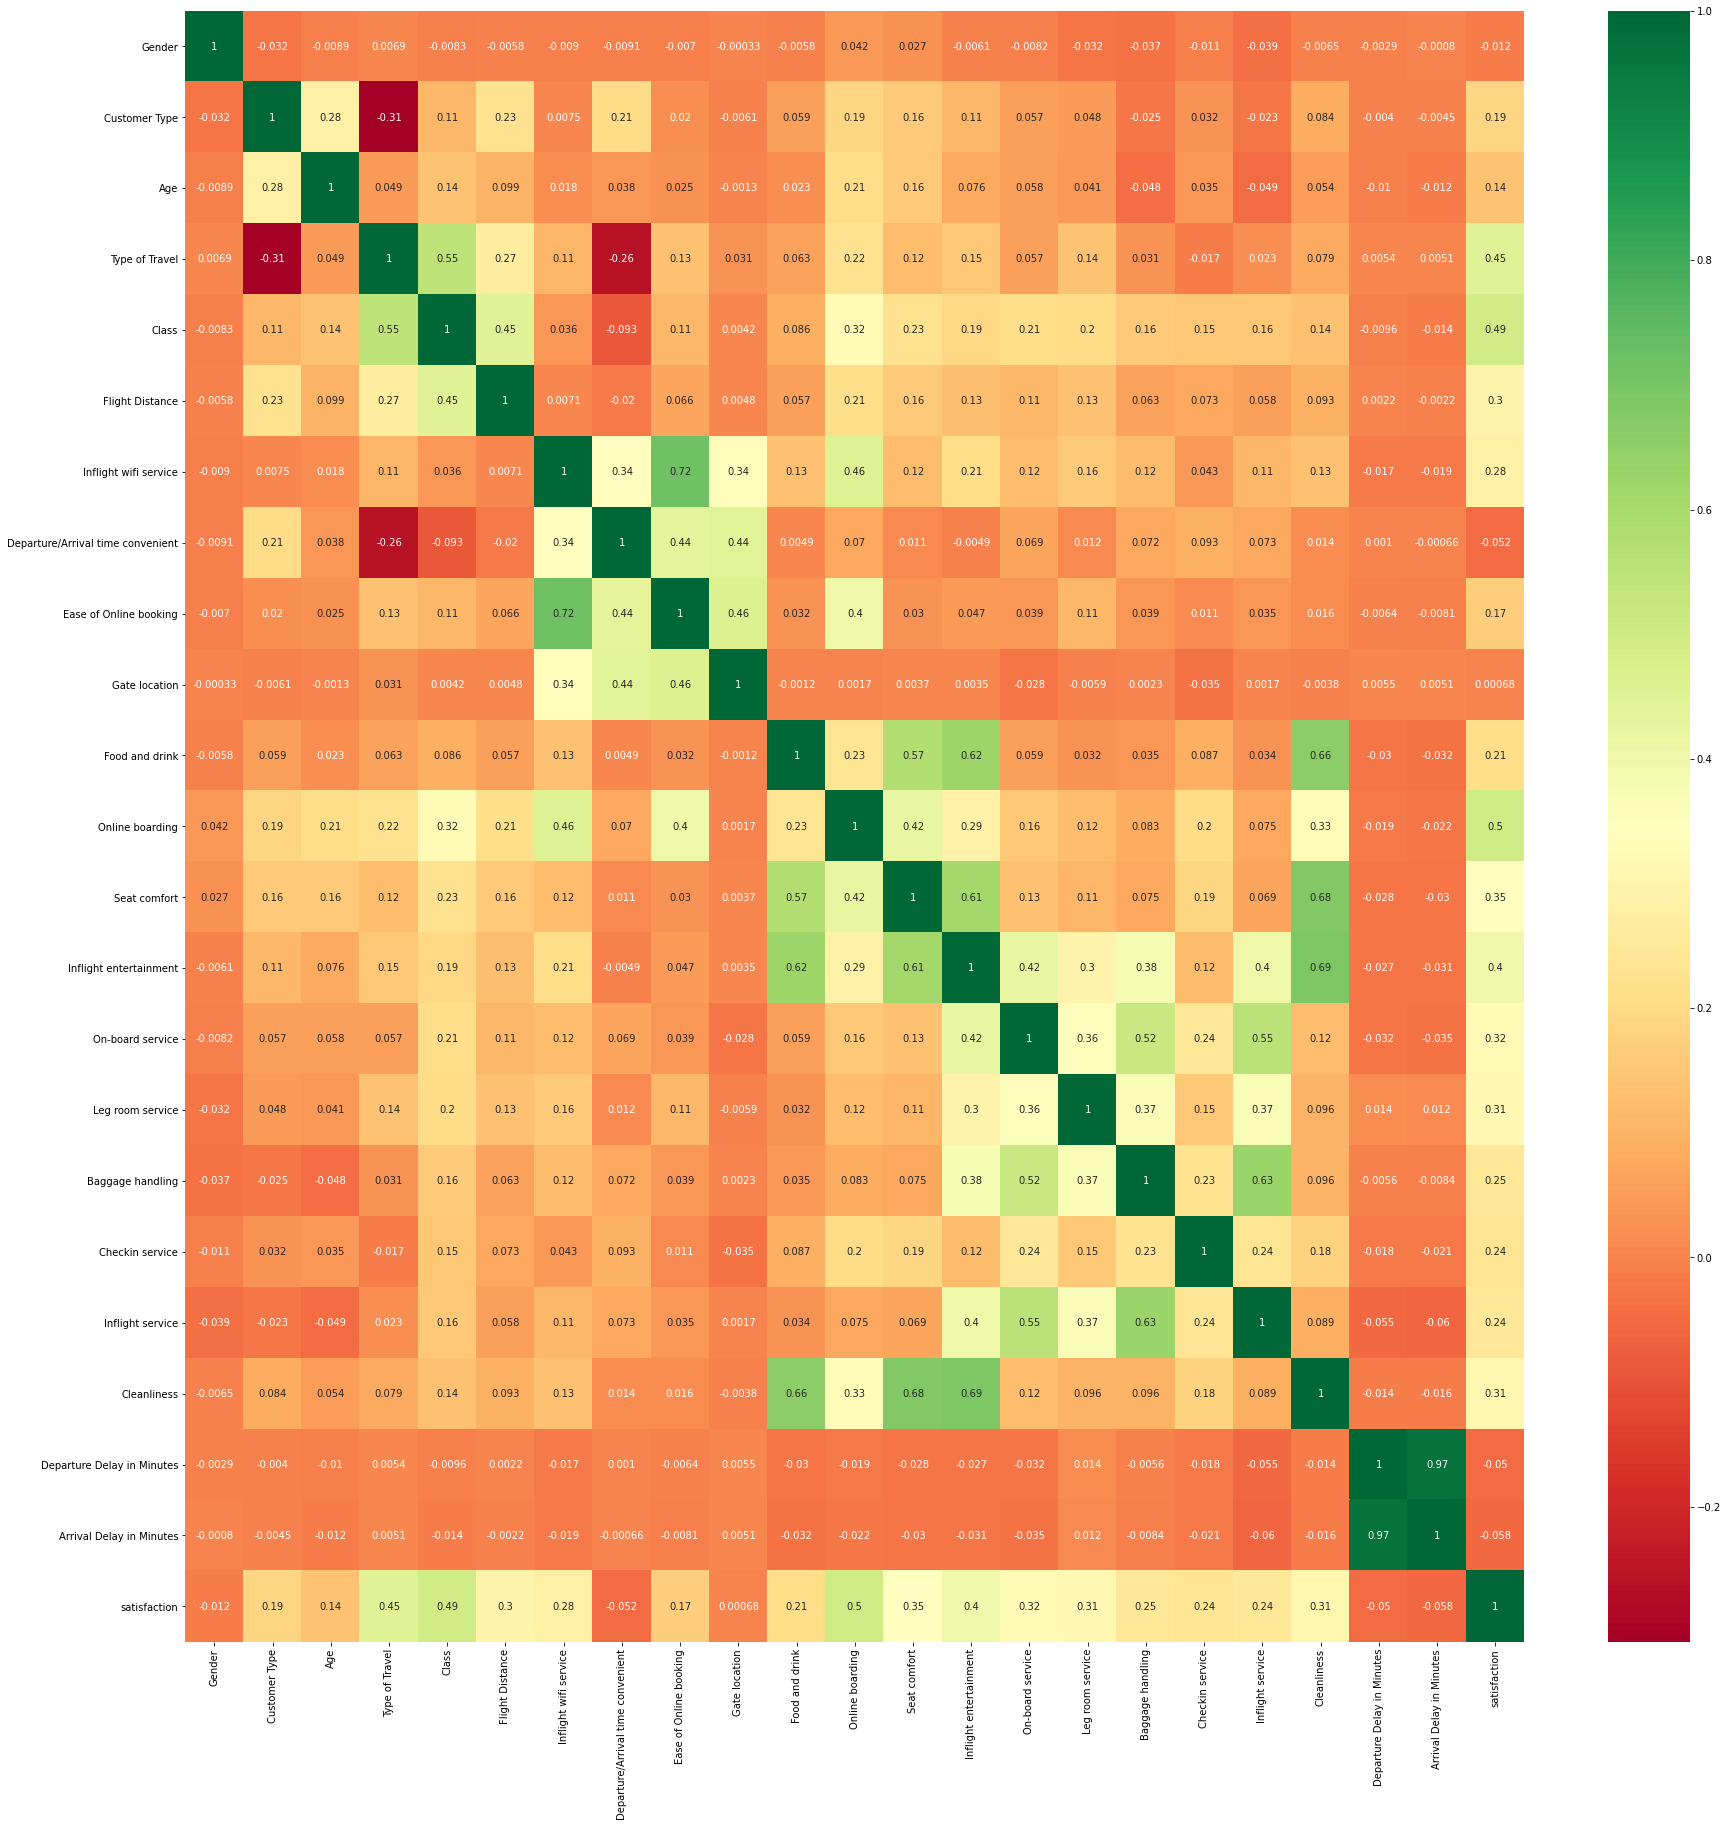

In [25]:
#heatmap
hmat = df_train.select_dtypes(exclude='object').corr()
top_corr_features = hmat.index
plt.figure(figsize=(30,30))
sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

##### 'Arrival Delay' and 'Departure Delay' feature is highly correlated. This two feature will be aggregated (by taking the average) to reduce multicollinearity.

In [26]:
df_train['Delay minutes'] = (df_train[num_col[2]] + df_train[num_col[3]])/2
df_train = df_train.drop(columns=[num_col[2],num_col[3]])

In [27]:
#recursive feature elimination with random forest
x = df_train.drop(columns=['satisfaction'])
y = df_train['satisfaction']

rfecv = RFECV(estimator=RandomForestClassifier(random_state=7), cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(x,y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=7,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

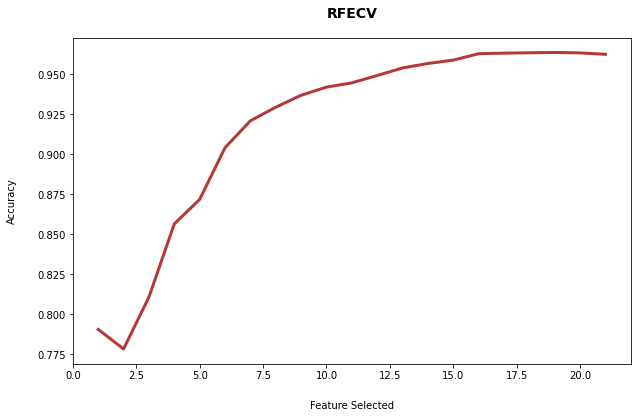

In [28]:
#Plot performance
plt.figure(figsize=(10, 6))
plt.title('RFECV', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Feature Selected', fontsize=10, labelpad=20)
plt.ylabel('Accuracy', fontsize=10, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#B53737', linewidth=3)

plt.show()

In [29]:
print('Best number of features: {}'.format(rfecv.n_features_))

Best number of features: 19


In [30]:
x = x.drop(x.columns[np.where(rfecv.support_ == False)[0]], axis=1)

In [31]:
print(np.where(rfecv.support_ == False)[0])

[ 0 10]


### Scaling and PCA (Principal Component Analysis)

In [32]:
sc = StandardScaler()
sc.fit(x)
x_scal = sc.transform(x)
x_scal = pd.DataFrame(x_scal, columns= x.columns)

In [33]:
#get components that satisfy atleast 95% variance
x_pca = PCA(n_components=0.95, whiten=True, random_state=7).fit_transform(x_scal)

In [34]:
x_pca.shape

(103904, 16)

### Model Training
##### a. Scaled with PCA data
##### b. Scaled without PCA data
##### with *SVM, Gaussian Naive Bayes, Logistic Regression* - (baseline model)

In [35]:
# Train-Test Split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.3, stratify= y, random_state=7)
X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(x_scal, y, test_size=0.3, stratify= y, random_state=7)

### a. Scaled with PCA data
##### SVM

In [62]:
#rbf
svc=SVC()
svc.fit(X_train_pca,y_train_pca)
y_pred=svc.predict(X_test_pca)
print('Accuracy Score - SVM(rbf):')
print(metrics.accuracy_score(y_test_pca,y_pred))

Accuracy Score - SVM(rbf):
0.9475490825099449


In [63]:
#linear
svc=SVC(kernel='linear')
svc.fit(X_train_pca,y_train_pca)
y_pred=svc.predict(X_test_pca)
print('Accuracy Score - SVM(linear):')
print(metrics.accuracy_score(y_test_pca,y_pred))

Accuracy Score - SVM(linear):
0.8679263441550109


In [64]:
#poly
svc=SVC(kernel='poly')
svc.fit(X_train_pca,y_train_pca)
y_pred=svc.predict(X_test_pca)
print('Accuracy Score - SVM(poly):')
print(metrics.accuracy_score(y_test_pca,y_pred))

Accuracy Score - SVM(poly):
0.921083023225972


##### Gaussian Naive Bayes

In [65]:
gnb = GaussianNB()
gnb.fit(X_train_pca, y_train_pca)
y_pred = gnb.predict(X_test_pca)
print('Accuracy Score - Naive Bayes:')
print(metrics.accuracy_score(y_test_pca,y_pred))

Accuracy Score - Naive Bayes:
0.826703451815732


##### Logistic Regression

In [66]:
lr = LogisticRegression()
lr.fit(X_train_pca, y_train_pca)
y_pred = lr.predict(X_test_pca)
print('Accuracy Score - LR:')
print(metrics.accuracy_score(y_test_pca,y_pred))

Accuracy Score - LR:
0.8639163351725908


### b. Scaled without PCA data
##### SVM

In [37]:
#rbf
svc=SVC()
svc.fit(X_train_scal,y_train_scal)
y_pred=svc.predict(X_test_scal)
print('Accuracy Score - SVM(rbf):')
print(metrics.accuracy_score(y_test_scal,y_pred))

Accuracy Score - SVM(rbf):
0.9554407801873476


In [69]:
#linear
svc=SVC(kernel='linear')
svc.fit(X_train_scal,y_train_scal)
y_pred=svc.predict(X_test_scal)
print('Accuracy Score - SVM(linear):')
print(metrics.accuracy_score(y_test_scal,y_pred))

Accuracy Score - SVM(linear):
0.8760426023354292


In [70]:
#poly
svc=SVC(kernel='poly')
svc.fit(X_train_scal,y_train_scal)
y_pred=svc.predict(X_test_scal)
print('Accuracy Score - SVM(poly):')
print(metrics.accuracy_score(y_test_scal,y_pred))

Accuracy Score - SVM(poly):
0.9393686641858078


##### Gaussian Naive Bayes

In [71]:
gnb = GaussianNB()
gnb.fit(X_train_scal, y_train_scal)
y_pred = gnb.predict(X_test_scal)
print('Accuracy Score - Naive Bayes:')
print(metrics.accuracy_score(y_test_scal,y_pred))

Accuracy Score - Naive Bayes:
0.8668356217117926


##### Logistic Regression

In [72]:
lr = LogisticRegression()
lr.fit(X_train_scal, y_train_scal)
y_pred = lr.predict(X_test_scal)
print('Accuracy Score - LR:')
print(metrics.accuracy_score(y_test_scal,y_pred))

Accuracy Score - LR:
0.8742781983831643


## Tuning Hyperparameter
##### Select *Scaled without PCA Data - SVM 'rbf'* for tuning

In [76]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}

grid = GridSearchCV( SVC(), param_grid, verbose=0, scoring='accuracy', n_jobs=-1, cv=5)
grid.fit(X_train_scal,y_train_scal)
grid.cv_results_['mean_test_score'], grid.cv_results_['params'], grid.best_params_, grid.best_score_

(array([0.715641  , 0.94098888, 0.91776664, 0.87760543, 0.84438761,
        0.95735029, 0.93678166, 0.89513554, 0.85709178, 0.95594788,
        0.94727222, 0.92035147, 0.85706428, 0.94366994, 0.95469672,
        0.93577798]),
 [{'C': 0.1, 'gamma': 1},
  {'C': 0.1, 'gamma': 0.1},
  {'C': 0.1, 'gamma': 0.01},
  {'C': 0.1, 'gamma': 0.001},
  {'C': 1, 'gamma': 1},
  {'C': 1, 'gamma': 0.1},
  {'C': 1, 'gamma': 0.01},
  {'C': 1, 'gamma': 0.001},
  {'C': 10, 'gamma': 1},
  {'C': 10, 'gamma': 0.1},
  {'C': 10, 'gamma': 0.01},
  {'C': 10, 'gamma': 0.001},
  {'C': 100, 'gamma': 1},
  {'C': 100, 'gamma': 0.1},
  {'C': 100, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.001}],
 {'C': 1, 'gamma': 0.1},
 0.9573502856054391)

In [36]:
svm_tuned = SVC(C=1,gamma=0.1)

### Preprocessing on Test Data
##### *Impute missing value, aggregate features, RFECV, scaling*

In [38]:
df_test = pd.read_csv(url2)

In [39]:
df_test = df_test.drop(columns=['Unnamed: 0','id'])

In [40]:
df_test.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [41]:
df_test.shape

(25976, 23)

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             25976 non-null  object 
 1   Customer Type                      25976 non-null  object 
 2   Age                                25976 non-null  int64  
 3   Type of Travel                     25976 non-null  object 
 4   Class                              25976 non-null  object 
 5   Flight Distance                    25976 non-null  int64  
 6   Inflight wifi service              25976 non-null  int64  
 7   Departure/Arrival time convenient  25976 non-null  int64  
 8   Ease of Online booking             25976 non-null  int64  
 9   Gate location                      25976 non-null  int64  
 10  Food and drink                     25976 non-null  int64  
 11  Online boarding                    25976 non-null  int

In [43]:
#impute missing value
Xmt = df_test.select_dtypes(exclude='object')
Xs_imputed = MFimputer.transform(Xmt)
Xs_imputed = pd.DataFrame(Xs_imputed, columns=Xmf.columns)  #convert array to dataframe
df_test['Arrival Delay in Minutes'] = Xs_imputed['Arrival Delay in Minutes']

Iteration: 0
Iteration: 1
Iteration: 2


In [44]:
#mapping label
df_test['Gender']=df_test['Gender'].map({'Female': 1,'Male': 0})
df_test['Customer Type']=df_test['Customer Type'].map({'Loyal Customer': 1,'disloyal Customer': 0})
df_test['Type of Travel']=df_test['Type of Travel'].map({'Business travel': 1,'Personal Travel': 0})
df_test['Class']=df_test['Class'].map({'Eco': 1,'Eco Plus': 2,'Business': 3})

df_test['satisfaction']=df_test['satisfaction'].map({'neutral or dissatisfied': 0,'satisfied': 1})

In [45]:
#aggregate feature
df_test['Delay minutes'] = (df_test[num_col[2]] + df_test[num_col[3]])/2
df_test = df_test.drop(columns=[num_col[2],num_col[3]])

In [46]:
#feature elimination
xs = df_test.drop(columns=['satisfaction'])
ys = df_test['satisfaction']

xs = xs.drop(xs.columns[np.where(rfecv.support_ == False)[0]], axis=1)

In [47]:
#scaling
xs_scal = sc.transform(xs)
xs_scal = pd.DataFrame(xs_scal, columns= xs.columns)

### Model Performance on Test Dataset

In [48]:
svm_tuned.fit(x_scal, y)
y_pred = svm_tuned.predict(xs_scal)
print('Accuracy Score - SVM tuned:')
print(metrics.accuracy_score(ys,y_pred))

Accuracy Score - SVM tuned:
0.9599245457345241


              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14573
           1       0.97      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

accuracy score: 95.992%


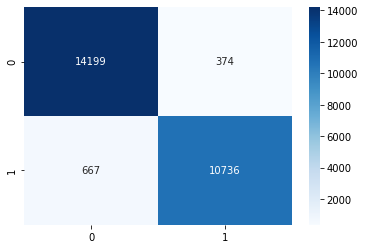

In [54]:
#Classification report and confusion matrix
print(metrics.classification_report(ys,y_pred))
print('accuracy score: %s' % '{0:.3%}'.format(metrics.accuracy_score(ys,y_pred)))
confusion = metrics.confusion_matrix(ys,y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')